In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

In [2]:
# Randomly sample 40% of the data
df_sampled = pd.read_csv("data/india_housing_prices.csv")
df = df_sampled.sample(frac=0.4, random_state=1)

In [3]:
df.isnull().sum()

ID                                0
State                             0
City                              0
Locality                          0
Property_Type                     0
BHK                               0
Size_in_SqFt                      0
Price_in_Lakhs                    0
Price_per_SqFt                    0
Year_Built                        0
Furnished_Status                  0
Floor_No                          0
Total_Floors                      0
Age_of_Property                   0
Nearby_Schools                    0
Nearby_Hospitals                  0
Public_Transport_Accessibility    0
Parking_Space                     0
Security                          0
Amenities                         0
Facing                            0
Owner_Type                        0
Availability_Status               0
dtype: int64

In [4]:
df.dtypes

ID                                  int64
State                              object
City                               object
Locality                           object
Property_Type                      object
BHK                                 int64
Size_in_SqFt                        int64
Price_in_Lakhs                    float64
Price_per_SqFt                    float64
Year_Built                          int64
Furnished_Status                   object
Floor_No                            int64
Total_Floors                        int64
Age_of_Property                     int64
Nearby_Schools                      int64
Nearby_Hospitals                    int64
Public_Transport_Accessibility     object
Parking_Space                      object
Security                           object
Amenities                          object
Facing                             object
Owner_Type                         object
Availability_Status                object
dtype: object

In [5]:
df.describe()

,ID,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Floor_No,Total_Floors,Age_of_Property,Nearby_Schools,Nearby_Hospitals
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,124959.142330,3.004440,2747.539990,254.828922,0.130909,2006.531090,14.97681,15.533060,18.468910,5.484320,5.492870
std,72260.556435,1.415655,1300.010761,141.653821,0.131504,9.808262,8.94920,8.676323,9.808262,2.878186,2.866543
min,2.000000,1.000000,500.000000,10.000000,0.000000,1990.000000,0.00000,1.000000,2.000000,1.000000,1.000000
25%,62588.500000,2.000000,1622.000000,132.320000,0.050000,1998.000000,7.00000,8.000000,10.000000,3.000000,3.000000
50%,124666.500000,3.000000,2746.000000,254.165000,0.090000,2007.000000,15.00000,16.000000,18.000000,5.000000,5.000000
75%,187780.000000,4.000000,3871.000000,377.390000,0.160000,2015.000000,23.00000,23.000000,27.000000,8.000000,8.000000
max,249997.000000,5.000000,5000.000000,499.990000,0.990000,2023.000000,30.00000,30.000000,35.000000,10.000000,10.000000


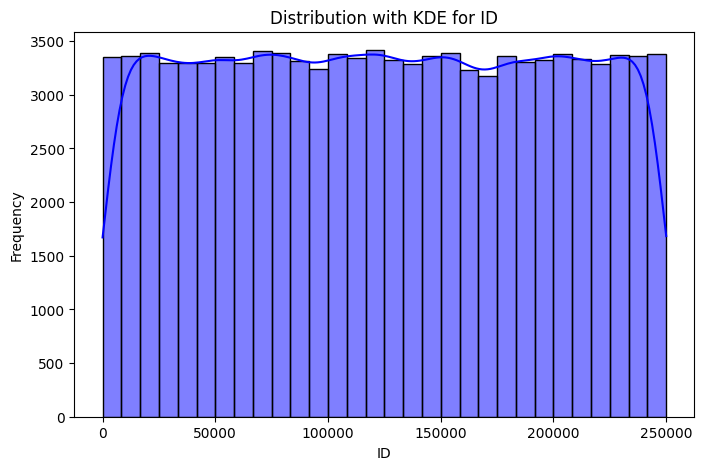

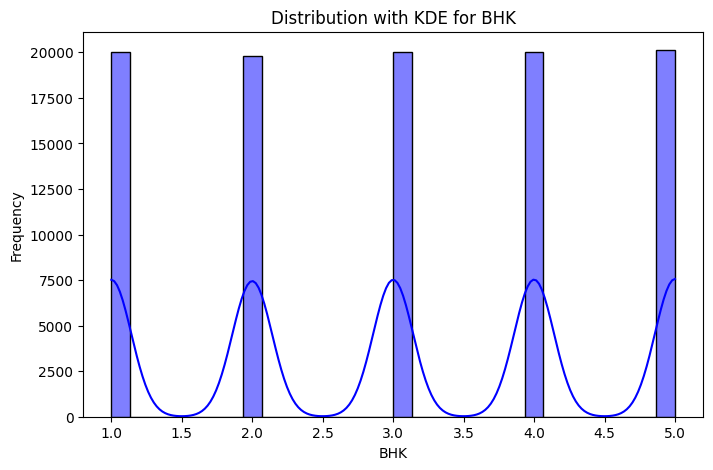

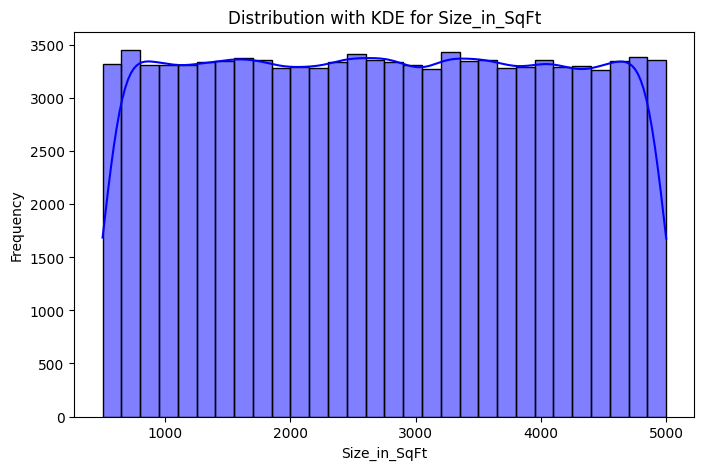

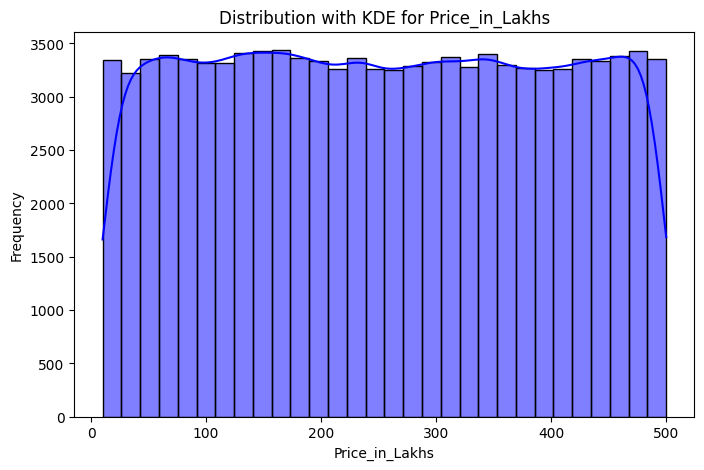

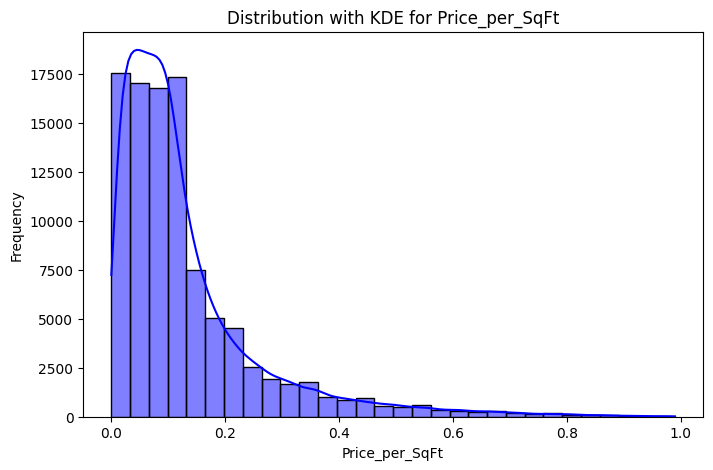

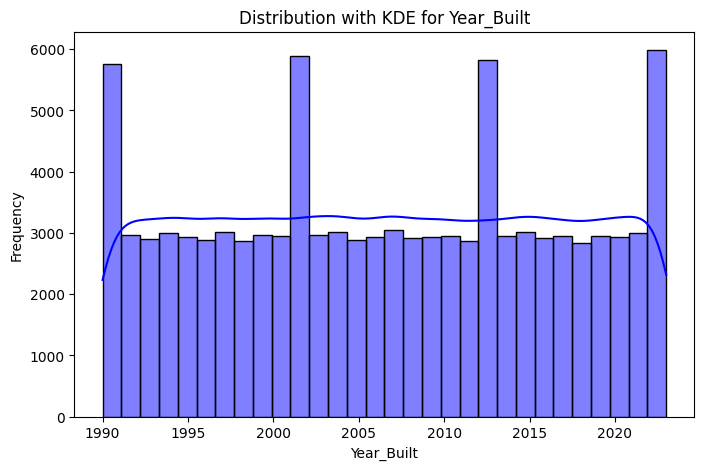

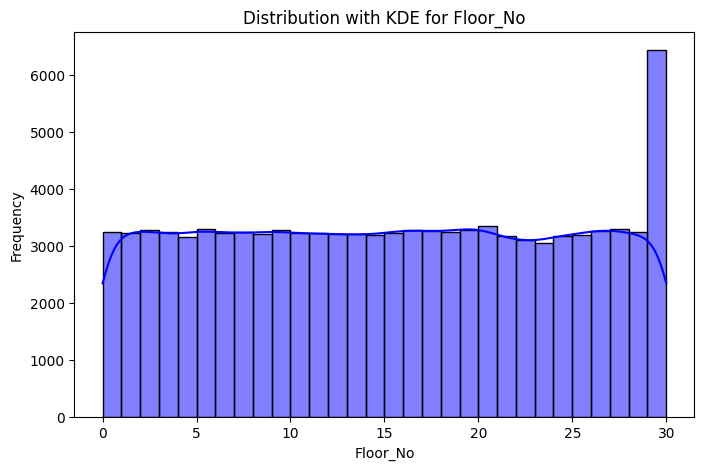

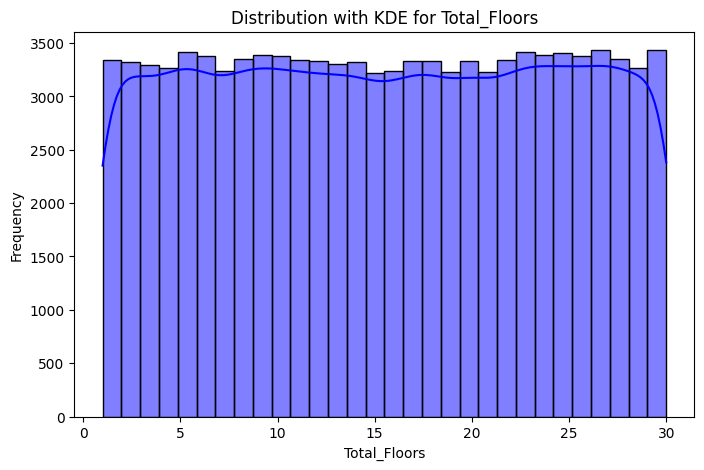

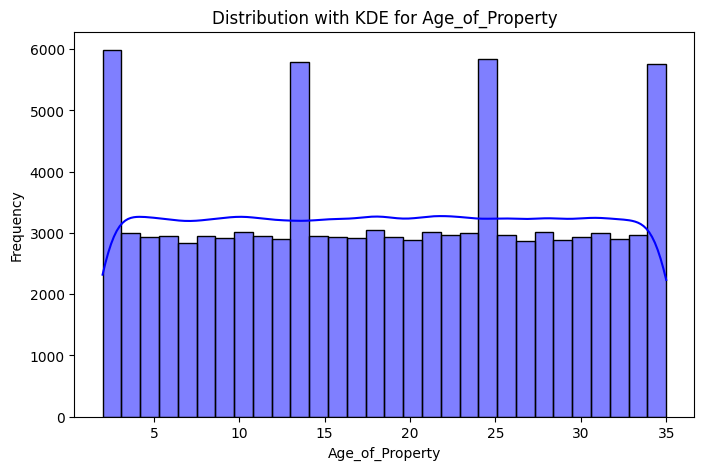

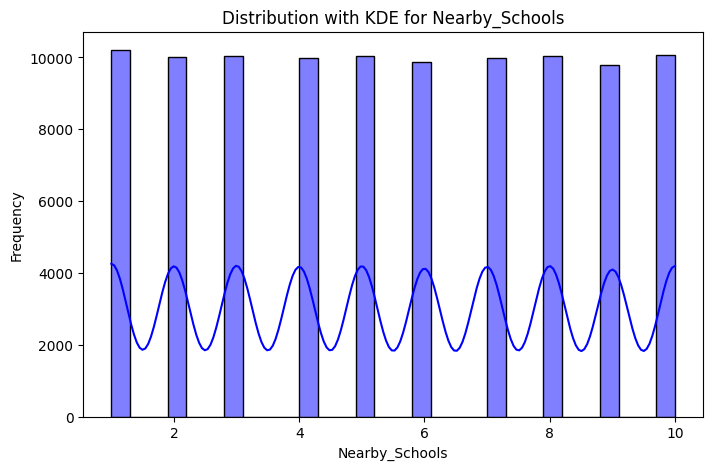

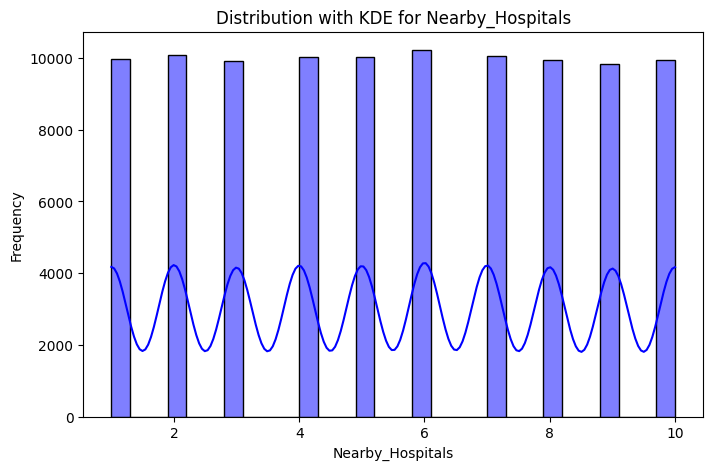

In [6]:
numerical_col = [column for column in df.columns if df[column].dtype != 'object'] # seperated numerical columns

for col in numerical_col:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution with KDE for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [7]:
#Dropping ID column since it's irrelevant
df.drop('ID', axis=1, inplace=True)


In [8]:
#Dropping Locality column since it's doesn't containg meaningful address
df.drop('Locality', axis=1, inplace=True)

In [9]:
#Using Ordinal Encoder to Encode Ordinal Values
ordinal_columns = ['Property_Type', 'Furnished_Status', 'Public_Transport_Accessibility', 'Facing', 'Security']

categories = [['Apartment', 'Independent House', 'Villa'],
              ['Unfurnished', 'Semi-furnished', 'Furnished'],
              ['Low', 'Medium', 'High'],
              ['South', 'East', 'West', 'North'],  # In India, west facing and north facing properties are more valuable
              ['No', 'Yes']]

encoder = OrdinalEncoder(categories=categories)
df[ordinal_columns] = encoder.fit_transform(df[ordinal_columns])

In [10]:
#Separating Categorical and Numerical columns
categorical_col = [column for column in df.columns if df[column].dtype == 'object']
numerical_col = [column for column in df.columns if df[column].dtype != 'object']

In [11]:
len(categorical_col), len(numerical_col)

(6, 15)

In [12]:
#Lower cap strings for better accessibility
for column in categorical_col:
    df[column] = df[column].str.lower()

In [13]:
df.head(3)

,State,City,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Furnished_Status,Floor_No,...,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
240208,karnataka,bangalore,0.0,5,3342,108.05,0.03,2013,2.0,14,...,12,4,1,1.0,no,0.0,"playground, pool, clubhouse, gym",3.0,owner,ready_to_move
18744,chhattisgarh,bilaspur,2.0,2,4417,25.74,0.01,2001,2.0,5,...,24,7,5,1.0,yes,1.0,"gym, pool, garden",0.0,builder,ready_to_move
207175,chhattisgarh,raipur,0.0,4,1850,41.04,0.02,2014,2.0,27,...,11,2,9,2.0,yes,1.0,garden,0.0,owner,under_construction


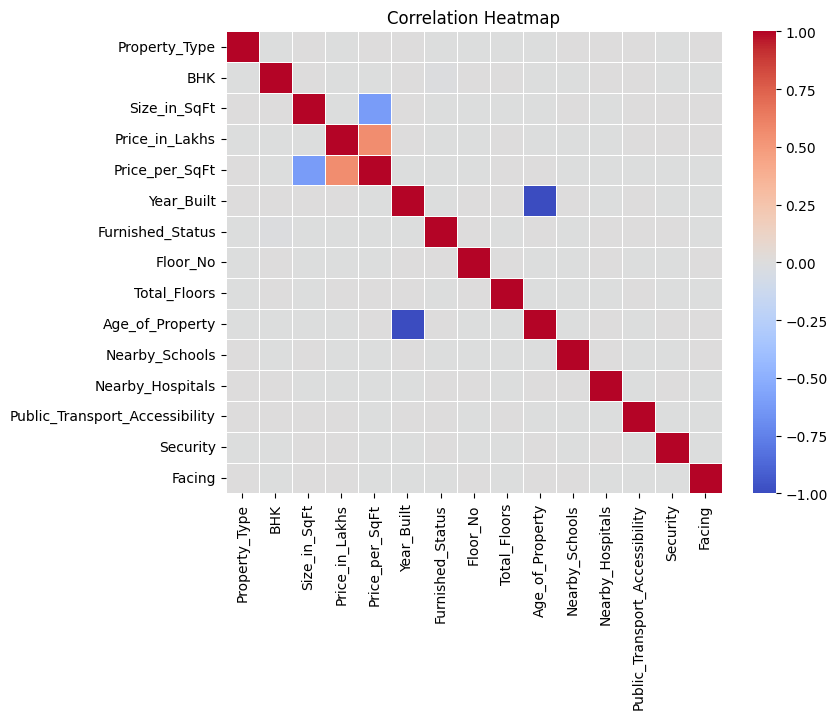

In [14]:
#Checking Correlation
correlation_matrix = df[numerical_col].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [15]:
#Setting up the validation framework
from sklearn.model_selection import train_test_split


df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.Price_in_Lakhs.values
y_val = df_val.Price_in_Lakhs.values
y_test = df_test.Price_in_Lakhs.values

del df_train['Price_in_Lakhs']
del df_val['Price_in_Lakhs']
del df_test['Price_in_Lakhs']

#df_full_train = df_full_train.reset_index(drop=True)

In [16]:
len(df_train), len(df_val), len(df_test)

(60000, 20000, 20000)

In [17]:
y_train

array([200.96, 144.58,  28.68, ..., 495.02, 425.58, 230.  ],
      shape=(60000,))

In [18]:
#Encoding Categorical Variables
#DictVectorizer automatically handles categorical columns

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [19]:
#Training The Model
#Training Using Different Models and Evaluating Their Results
#Helper function and list to evaluate models and store scores

model_results = []

def evaluate_model(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    return mae, mse, float(rmse), r2

In [20]:
######### Linear Regression ##########

model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",-1
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [21]:
y_pred = model.predict(X_val)
mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
mae, mse, rmse, r2

(80.9586096307691, 10127.178631461367, 100.63388411196979, 0.49217592168101454)

In [22]:
model_results.append({
    "Model": "Linear Regression",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
})

In [23]:
############# Decision Tree ###############
#Tuning Parameter

scores = []

for i in range(1, 12):
    for min_sample_leaf_values in [1, 3, 4, 5, 6, 8, 10, 15]:
        dt = DecisionTreeRegressor(max_depth=i, min_samples_leaf=min_sample_leaf_values, random_state=1)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)

        scores.append((i, min_sample_leaf_values, mae, mse, rmse, r2))

In [24]:
df_scores = pd.DataFrame(scores, columns=['depth', 'leaf', 'mae', 'mse', 'rmse', 'r2'])

In [25]:
df_scores

,depth,leaf,mae,mse,rmse,r2
0,1,1,81.487048,9748.974099,98.736893,0.511141
1,1,3,81.487048,9748.974099,98.736893,0.511141
2,1,4,81.487048,9748.974099,98.736893,0.511141
3,1,5,81.487048,9748.974099,98.736893,0.511141
4,1,6,81.487048,9748.974099,98.736893,0.511141
...,...,...,...,...,...,...
83,11,5,9.418303,150.658808,12.274315,0.992445
84,11,6,9.424797,150.673502,12.274914,0.992445
85,11,8,9.427693,150.337382,12.261215,0.992461
86,11,10,9.416970,150.066679,12.250171,0.992475


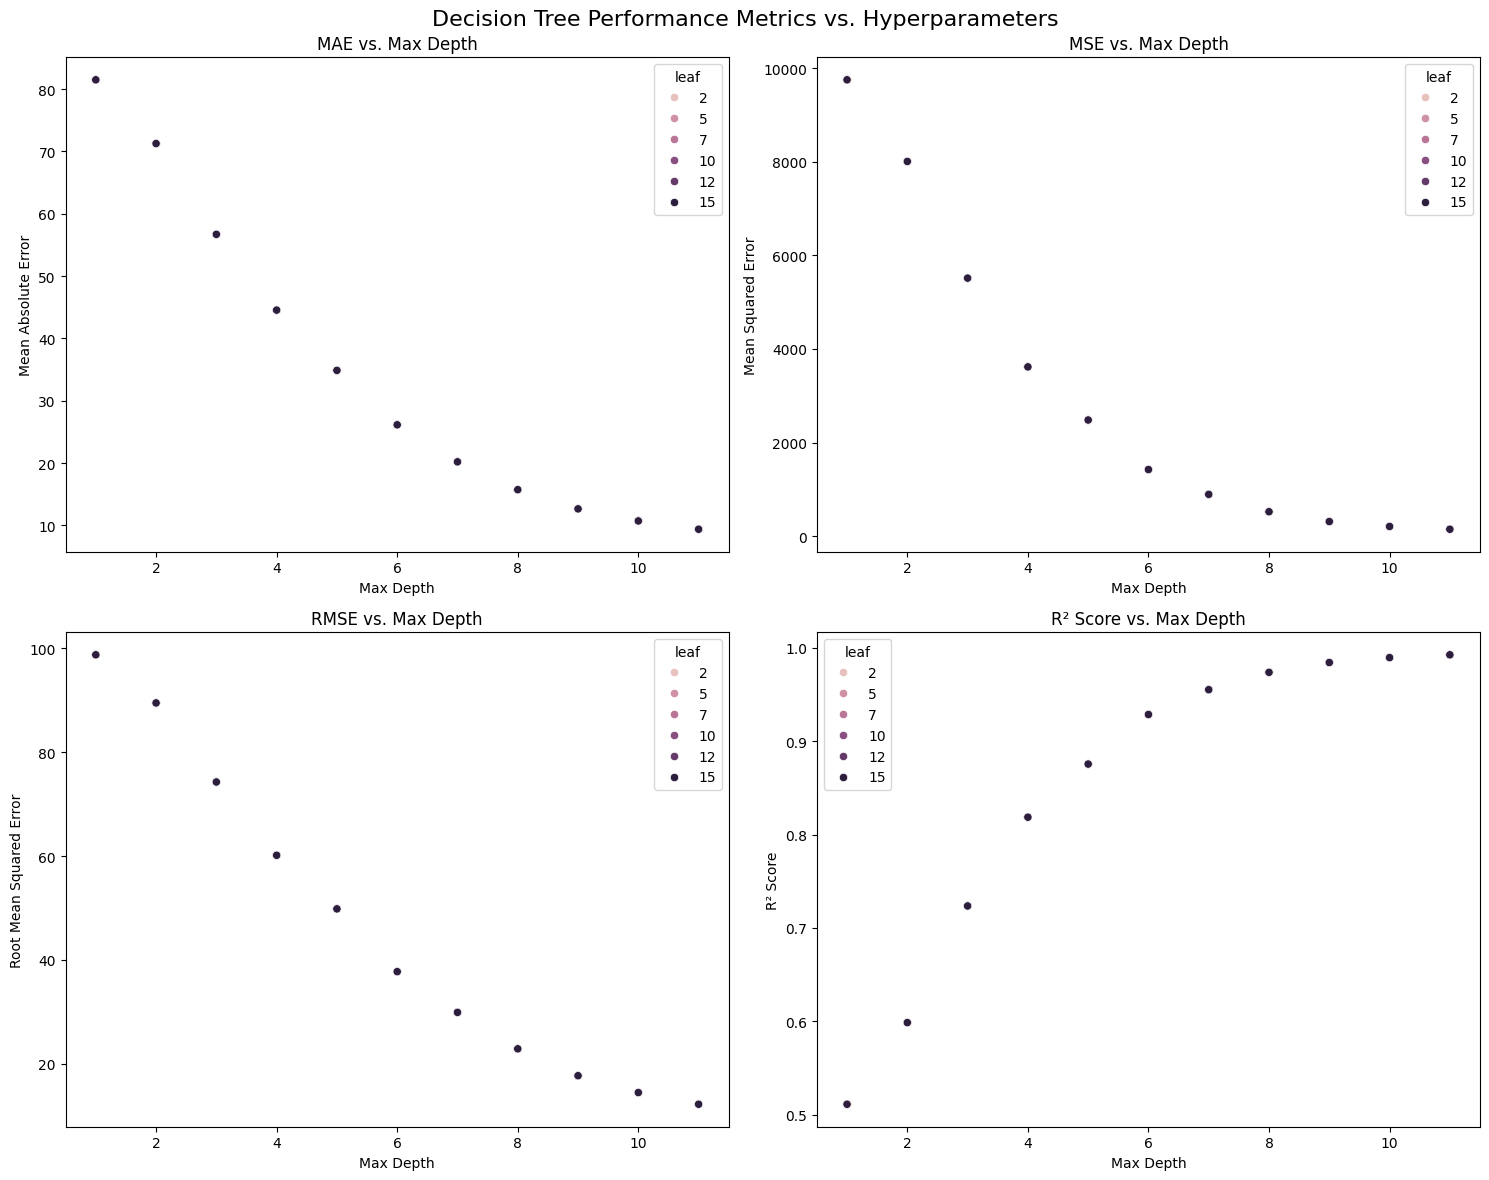


Best Parameters for different metrics:

Best parameters for minimum MAE:
depth     11.000000
leaf      15.000000
mae        9.382879
mse      149.235504
rmse      12.216198
r2         0.992517
Name: 87, dtype: float64

Best parameters for minimum MSE:
depth     11.000000
leaf      15.000000
mae        9.382879
mse      149.235504
rmse      12.216198
r2         0.992517
Name: 87, dtype: float64

Best parameters for minimum RMSE:
depth     11.000000
leaf      15.000000
mae        9.382879
mse      149.235504
rmse      12.216198
r2         0.992517
Name: 87, dtype: float64

Best parameters for maximum R2:
depth     11.000000
leaf      15.000000
mae        9.382879
mse      149.235504
rmse      12.216198
r2         0.992517
Name: 87, dtype: float64


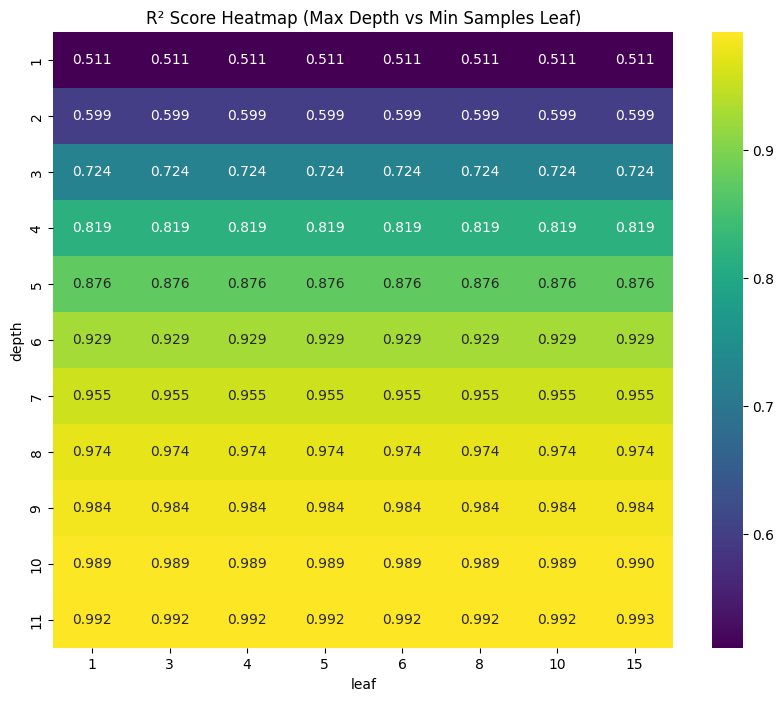

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Decision Tree Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='depth', y='mae', hue='leaf', ax=axes[0,0])
axes[0,0].set_title('MAE vs. Max Depth')
axes[0,0].set_xlabel('Max Depth')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='depth', y='mse', hue='leaf', ax=axes[0,1])
axes[0,1].set_title('MSE vs. Max Depth')
axes[0,1].set_xlabel('Max Depth')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='rmse', hue='leaf', ax=axes[1,0])
axes[1,0].set_title('RMSE vs. Max Depth')
axes[1,0].set_xlabel('Max Depth')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='r2', hue='leaf', ax=axes[1,1])
axes[1,1].set_title('R² Score vs. Max Depth')
axes[1,1].set_xlabel('Max Depth')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

# Find the best parameters based on different metrics
print("\nBest Parameters for different metrics:")
print("\nBest parameters for minimum MAE:")
print(df_scores.loc[df_scores['mae'].idxmin()])

print("\nBest parameters for minimum MSE:")
print(df_scores.loc[df_scores['mse'].idxmin()])

print("\nBest parameters for minimum RMSE:")
print(df_scores.loc[df_scores['rmse'].idxmin()])

print("\nBest parameters for maximum R2:")
print(df_scores.loc[df_scores['r2'].idxmax()])

# Create a heatmap for R2 scores
plt.figure(figsize=(10, 8))
pivot_table = df_scores.pivot(index='depth', columns='leaf', values='r2')
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f')
plt.title('R² Score Heatmap (Max Depth vs Min Samples Leaf)')
plt.show()

In [27]:
#Choosing Leaf = 15 and depth = 20 since the scores are improving as depth increases
dt = DecisionTreeRegressor(max_depth=20, min_samples_leaf=15, random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
mae, mse, rmse, r2 

(7.908529242186917, 101.53338869206183, 10.076377756518552, 0.9949086412506867)

In [28]:
model_results.append({
    "Model": "Decision Tree",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
})

In [29]:
############ Random Forest ############

rf = RandomForestRegressor(random_state=1, n_jobs=-1, max_features='sqrt')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
mae, mse, rmse, r2 

(43.3619141225, 2944.8062800257594, 54.266069325369045, 0.852333646970909)

In [30]:
#Tuning N_estimator

scores = []

for n in range(10, 301, 40): # going to 200 with 40 steps
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1, max_features='sqrt')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
    mae, mse, rmse, r2 
    scores.append((n, mae, mse, rmse, r2))

In [31]:
df_scores = pd.DataFrame(scores, columns=['n_estimator', 'mae', 'mse', 'rmse', 'r2'])

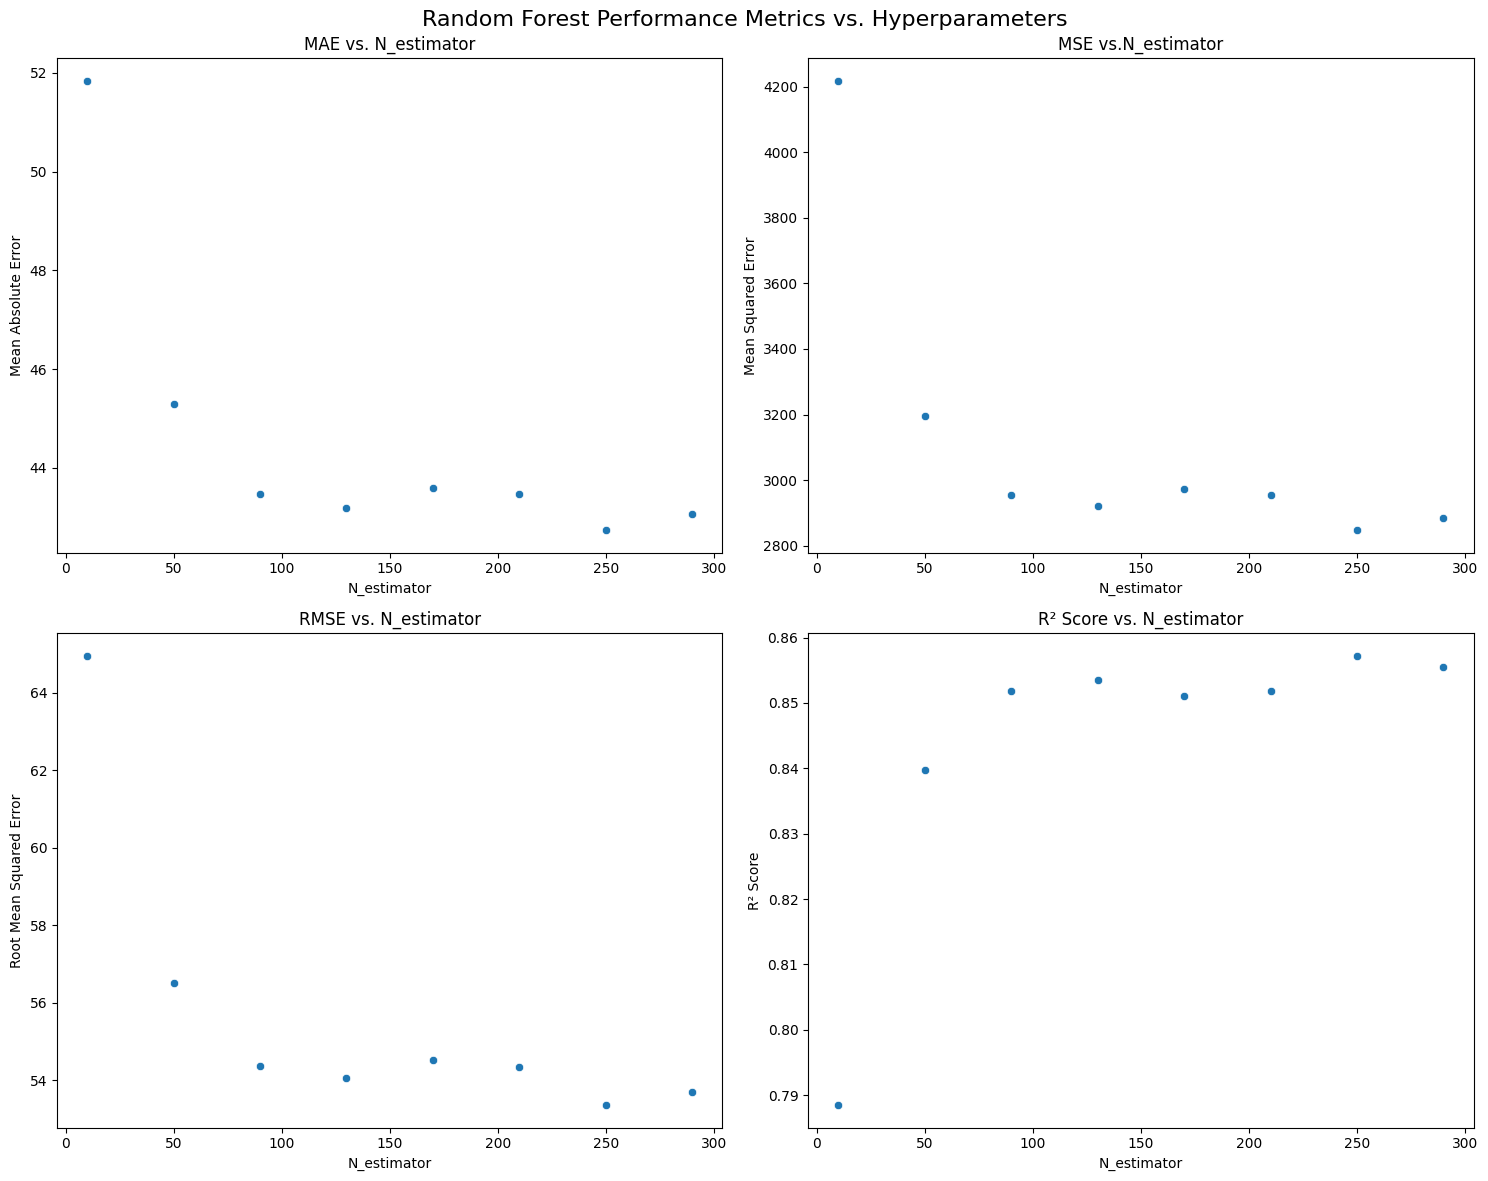

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='n_estimator', y='mae', ax=axes[0,0], marker='o')
axes[0,0].set_title('MAE vs. N_estimator')
axes[0,0].set_xlabel('N_estimator')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='n_estimator', y='mse', ax=axes[0,1], marker='o')
axes[0,1].set_title('MSE vs.N_estimator')
axes[0,1].set_xlabel('N_estimator')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='n_estimator', y='rmse', ax=axes[1,0], marker='o')
axes[1,0].set_title('RMSE vs. N_estimator')
axes[1,0].set_xlabel('N_estimator')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='n_estimator', y='r2', ax=axes[1,1], marker='o')
axes[1,1].set_title('R² Score vs. N_estimator')
axes[1,1].set_xlabel('N_estimator')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

In [33]:
#Tuning depths

scores = []

for d in [1, 3, 5, 10, 20, 25, 35, 50]: # tuning depths
    rf = RandomForestRegressor(max_depth=d ,n_estimators=100, random_state=1, n_jobs=-1, 
                               max_features='sqrt', verbose=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
    mae, mse, rmse, r2 
    scores.append((d, mae, mse, rmse, r2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.2s
[Parall

In [34]:
df_scores = pd.DataFrame(scores, columns=['depth', 'mae', 'mse', 'rmse', 'r2'])

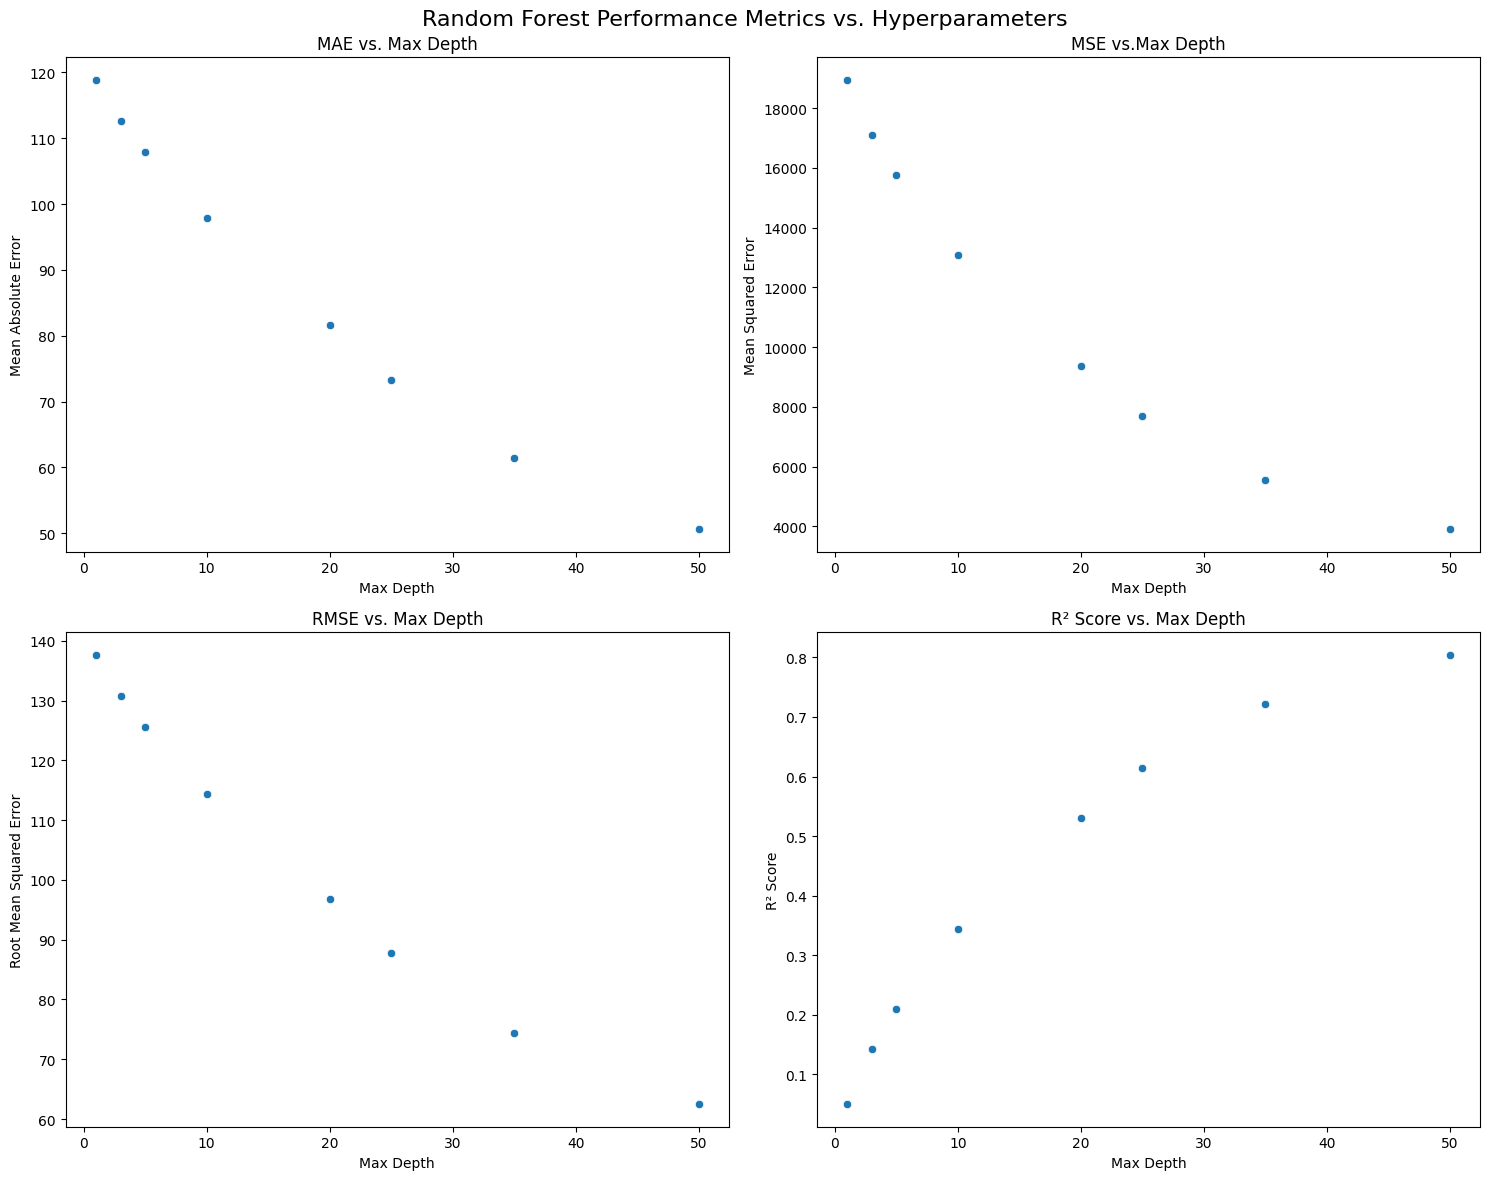

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='depth', y='mae', ax=axes[0,0], marker='o')
axes[0,0].set_title('MAE vs. Max Depth')
axes[0,0].set_xlabel('Max Depth')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='depth', y='mse', ax=axes[0,1], marker='o')
axes[0,1].set_title('MSE vs.Max Depth')
axes[0,1].set_xlabel('Max Depth')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='rmse', ax=axes[1,0], marker='o')
axes[1,0].set_title('RMSE vs. Max Depth')
axes[1,0].set_xlabel('Max Depth')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='depth', y='r2', ax=axes[1,1], marker='o')
axes[1,1].set_title('R² Score vs. Max Depth')
axes[1,1].set_xlabel('Max Depth')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

In [36]:
#Taking max_depth 50 and tuning min_sample_leaf

scores = []

for s in [1, 3, 5, 10, 20, 35]: # tuning depths
    rf = RandomForestRegressor(max_depth=50 ,n_estimators=100, min_samples_leaf=s, random_state=1, n_jobs=-1, 
                               max_features='sqrt', verbose=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
    mae, mse, rmse, r2 
    scores.append((s, mae, mse, rmse, r2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.5s
[Parall

In [37]:
df_scores = pd.DataFrame(scores, columns=['leaf', 'mae', 'mse', 'rmse', 'r2'])

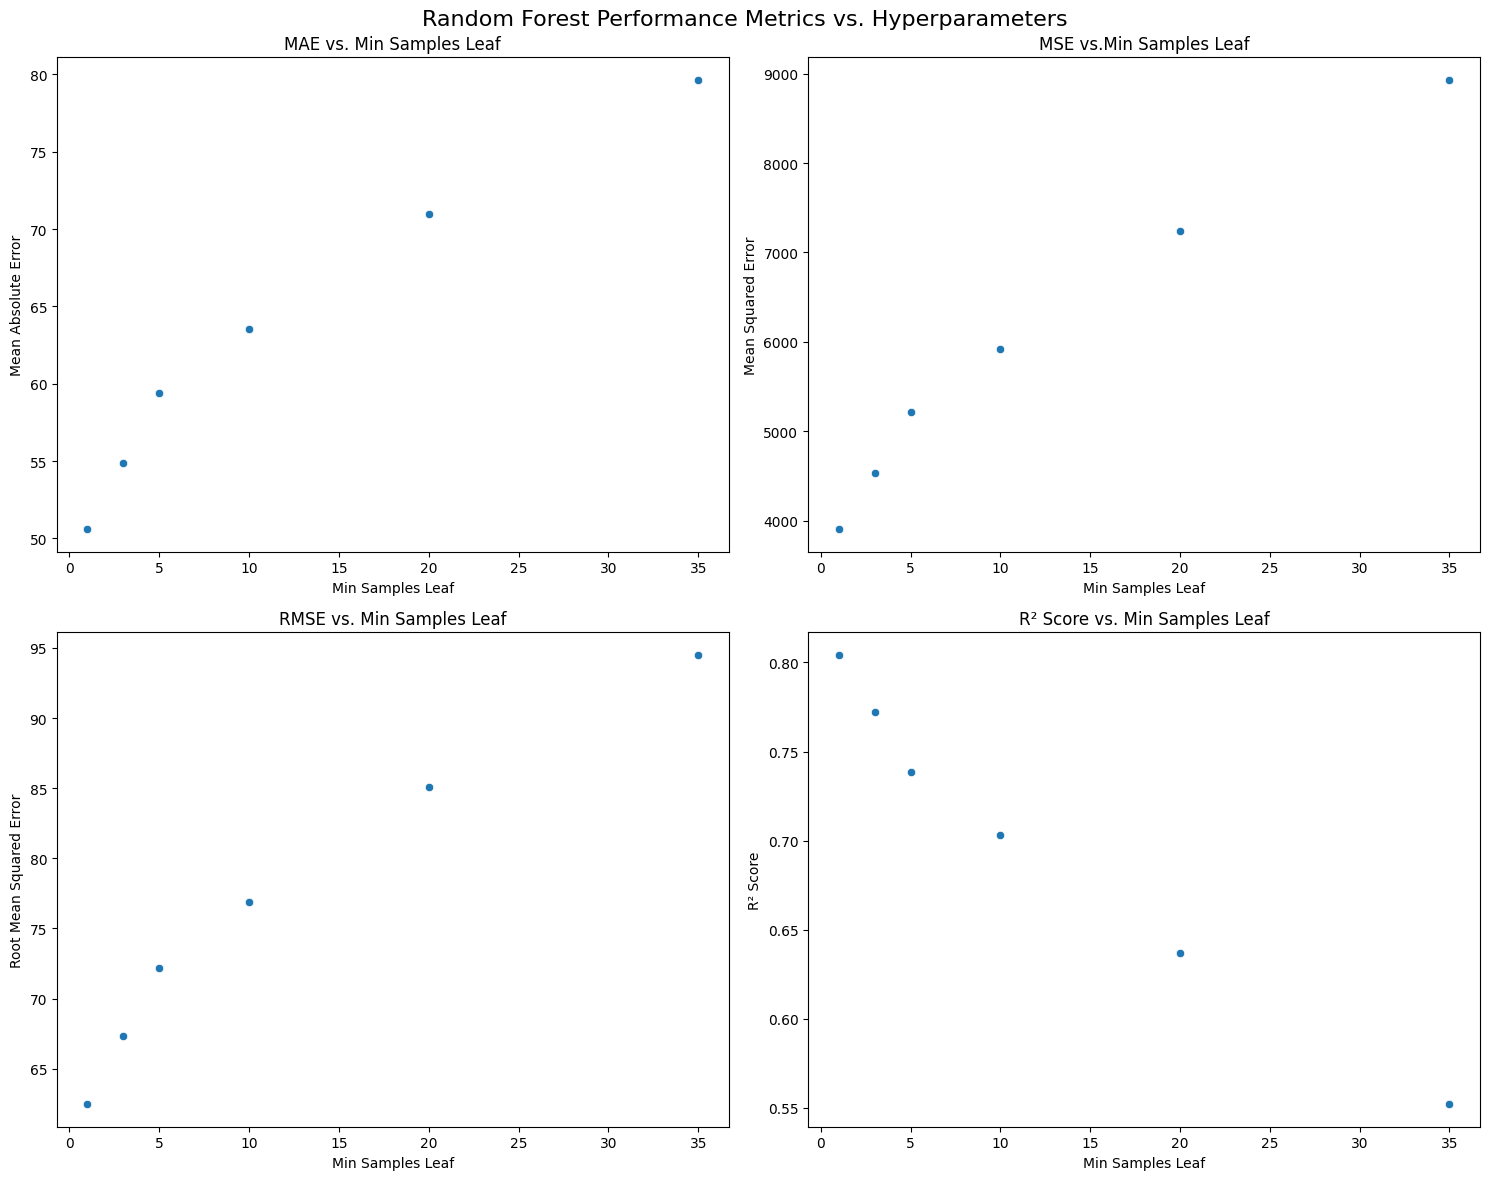

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Performance Metrics vs. Hyperparameters', fontsize=16)

sns.scatterplot(data=df_scores, x='leaf', y='mae', ax=axes[0,0], marker='o')
axes[0,0].set_title('MAE vs. Min Samples Leaf')
axes[0,0].set_xlabel('Min Samples Leaf')
axes[0,0].set_ylabel('Mean Absolute Error')

sns.scatterplot(data=df_scores, x='leaf', y='mse', ax=axes[0,1], marker='o')
axes[0,1].set_title('MSE vs.Min Samples Leaf')
axes[0,1].set_xlabel('Min Samples Leaf')
axes[0,1].set_ylabel('Mean Squared Error')

sns.scatterplot(data=df_scores, x='leaf', y='rmse', ax=axes[1,0], marker='o')
axes[1,0].set_title('RMSE vs. Min Samples Leaf')
axes[1,0].set_xlabel('Min Samples Leaf')
axes[1,0].set_ylabel('Root Mean Squared Error')

sns.scatterplot(data=df_scores, x='leaf', y='r2', ax=axes[1,1], marker='o')
axes[1,1].set_title('R² Score vs. Min Samples Leaf')
axes[1,1].set_xlabel('Min Samples Leaf')
axes[1,1].set_ylabel('R² Score')

plt.tight_layout()
plt.show()

In [39]:
#Taking Min_sample_leaf = 1

rf = RandomForestRegressor(max_depth=50 ,n_estimators=100, min_samples_leaf=1, random_state=1, n_jobs=-1, max_features='sqrt', verbose=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
mae, mse, rmse, r2 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished


(50.594103804150585, 3902.519560861042, 62.470149358401905, 0.8043094260271684)

In [40]:
model_results.append({
    "Model": "Random Forest",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
})

In [41]:
####### XGBoost #########

features_name = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_name)
dval = xgb.DMatrix(X_val, feature_names=features_name)

In [42]:
xgb = XGBRegressor(random_state=1, objective='reg:squarederror')

In [43]:
param_grid = {
    'tree_method': ['hist'],  # Use 'hist' tree_method
    'device': ['cuda'],  # Use GPU via CUDA
    'n_estimators': [100],  # Number of boosting rounds
    'max_depth': [3, 10, 20],         # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
}

In [44]:
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Negative MSE (higher is better)
    cv=3,                             # 3-fold cross-validation
    verbose=1,                        # Show progress
    n_jobs=-1                         # Use all CPUs
)

In [45]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [02:53:13] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [02:53:13] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [02:53:13] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [02:53:13] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iterati

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'device': ['cuda'], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 10, ...], 'n_estimators': [100], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and 

In [46]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)  # Convert back from negative MSE

Best Parameters: {'device': 'cuda', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'tree_method': 'hist'}
Best Score: 82.3619497348708


In [47]:
xgb = XGBRegressor(tree_method='hist',
                   device='cuda',
                   n_estimators=100,
                   max_depth=10,
                   learning_rate=0.1,
                   random_state=1, objective='reg:squarederror')

xgb.fit(X_train, y_train)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [02:56:22] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [02:56:22] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",'cuda'
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabet

In [48]:
y_pred = xgb.predict(X_val)
mae, mse, rmse, r2 = evaluate_model(y_val, y_pred)
mae, mse, rmse, r2 

(7.077327910274506, 81.86584215959728, 9.047974478279505, 0.9958948639741229)

In [49]:
model_results.append({
    "Model": "XGBoost",
    "MAE": mae,
    "MSE": mse,
    "RMSE": rmse,
    "R2": r2
})

In [50]:
model_results

[{'Model': 'Linear Regression',
  'MAE': 80.9586096307691,
  'MSE': 10127.178631461367,
  'RMSE': 100.63388411196979,
  'R2': 0.49217592168101454},
 {'Model': 'Decision Tree',
  'MAE': 7.908529242186917,
  'MSE': 101.53338869206183,
  'RMSE': 10.076377756518552,
  'R2': 0.9949086412506867},
 {'Model': 'Random Forest',
  'MAE': 50.594103804150585,
  'MSE': 3902.519560861042,
  'RMSE': 62.470149358401905,
  'R2': 0.8043094260271684},
 {'Model': 'XGBoost',
  'MAE': 7.077327910274506,
  'MSE': 81.86584215959728,
  'RMSE': 9.047974478279505,
  'R2': 0.9958948639741229}]

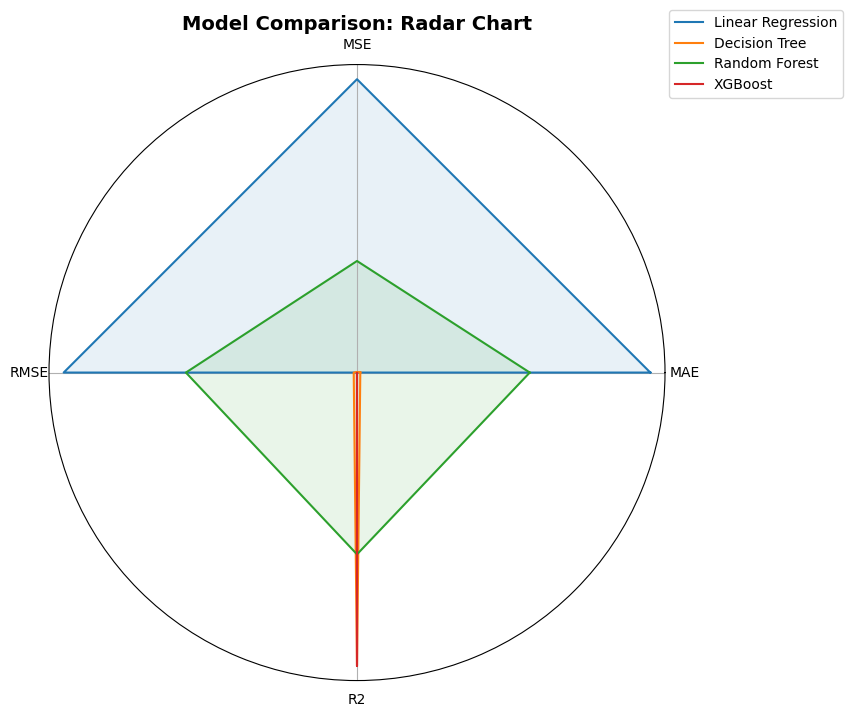

In [54]:
#Evaluating Best Model

df = pd.DataFrame(model_results)

# Normalize metrics for better visualization (0-1 scale)
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
normalized_df = df.copy()
for metric in metrics:
    normalized_df[metric] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

# Radar chart setup
labels = metrics
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in normalized_df.iterrows():
    values = row[metrics].tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, label=row['Model'])
    ax.fill(angles, values, alpha=0.1)

ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Model Comparison: Radar Chart", fontsize=14, weight='bold')

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.savefig('img/model_comparison_radar_chart.png', dpi=300)  # Save to the output directory

plt.show()

/tmp/ipykernel_3534/429031700.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df, ax=ax, palette=colors)
/tmp/ipykernel_3534/429031700.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_3534/429031700.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=df, ax=ax, palette=colors)
/tmp/ipykernel_3534/429031700.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(

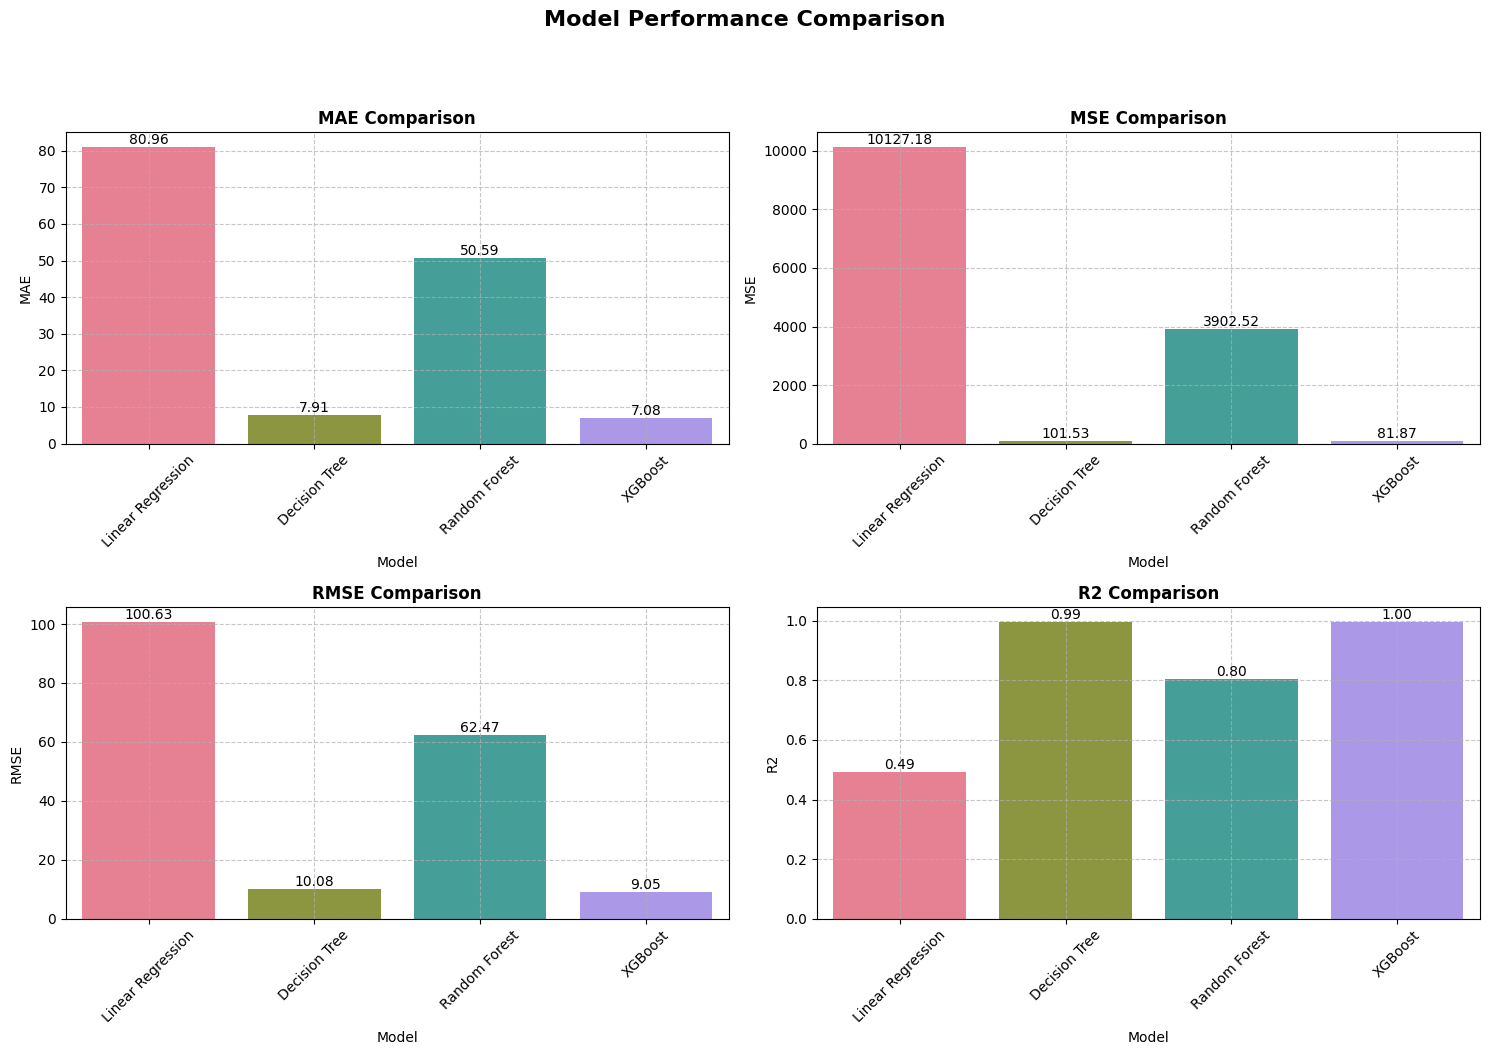

In [55]:
df = pd.DataFrame(model_results)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.05)

axes = axes.flatten()

metrics = ['MAE', 'MSE', 'RMSE', 'R2']
colors = sns.color_palette("husl", 4)

for i, (metric, ax) in enumerate(zip(metrics, axes)):
    sns.barplot(x='Model', y=metric, data=df, ax=ax, palette=colors)
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add value labels on top of each bar
    for j, v in enumerate(df[metric]):
        ax.text(j, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('img/model_comparison_bar_chart.png', dpi=300)  # Save to the output directory

plt.show()

XGBoost clearly performed well here. Do note that for RMSE, MSE, and MAE metrics, the lower the value the better, For R2, higher values indicate better benchmark.

Training the final model
Saving the model

In [58]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.Price_in_Lakhs.values
del df_full_train['Price_in_Lakhs']


AttributeError: 'DataFrame' object has no attribute 'Price_in_Lakhs'

In [59]:
xgb.fit(df_full_train, y_full_train)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:State: object, City: object, Parking_Space: object, Amenities: object, Owner_Type: object, Availability_Status: object